In [100]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import os
import warnings

# Ignore warnings of a specific type (DeprecationWarning in this case)
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [106]:
### Patient 100 example

# Reading ecg data
df_ecg = pd.read_csv('data/100.csv', quotechar="'")
df_ecg.rename(columns={'sample #':'Sample #'}, inplace=True)

# Reading annotations
df_annotations = pd.read_csv('data/100annotations.txt', sep='\s+')
df_annotations['Aux'] = df_annotations['Num'] 
df_annotations['Num'] = df_annotations['Chan']
df_annotations['Chan'] = df_annotations['Sub']
df_annotations['Sub'] = df_annotations['Type']
df_annotations['Type'] = df_annotations['#']
df_annotations.rename(columns={'Sample':'Sample #'}, inplace=True)
df_annotations.drop('#', axis=1, inplace=True)

# Merging ecg and annotations
df = pd.merge(df_ecg, df_annotations, on='Sample #', how='outer')



# Find the first row where AUX is not NaN
index_first_non_nan = df["Aux"].first_valid_index()
if index_first_non_nan is not None:
    df = df.loc[index_first_non_nan:]

# Scaling MLII and V5
scaler = MinMaxScaler()
MLII = df['MLII'].to_numpy()
V5 = df['V5'].to_numpy()
df['MLII'] = scaler.fit_transform(MLII.reshape(-1, 1))
df['V5'] = scaler.fit_transform(V5.reshape(-1, 1))

# Filtering MLII and V5 with moving average
df['MLII'] = df['MLII'].rolling(window=8, min_periods=1).mean()
df['V5'] = df['V5'].rolling(window=8, min_periods=1).mean()

df.reset_index(drop=True, inplace=True)

df_copy = df.dropna(subset=['Time']).copy()
df_copy.reset_index(drop=True, inplace=True)

# Plotting MLII and V5
plt.figure(figsize=(20, 10))
plt.plot(df['Sample #'][1000:2100], df['MLII'][1000:2100])
plt.plot(df['Sample #'][1000:2100], df['V5'][1000:2100])

    Sample #      MLII        V5      Time Type  Sub  Chan  Num  Aux
0         18  0.613253  0.654472  0:00.050    +  0.0   0.0  0.0   (N
1         77  0.717922  0.765075  0:00.214    N  0.0   0.0  0.0  NaN
2        370  0.738102  0.750000  0:01.028    N  0.0   0.0  0.0  NaN
3        662  0.679367  0.778455  0:01.839    N  0.0   0.0  0.0  NaN
4        946  0.673494  0.772358  0:02.628    N  0.0   0.0  0.0  NaN
5       1231  0.686747  0.725271  0:03.419    N  0.0   0.0  0.0  NaN
6       1515  0.707681  0.743225  0:04.208    N  0.0   0.0  0.0  NaN
7       1809  0.710542  0.816396  0:05.025    N  0.0   0.0  0.0  NaN
8       2044  0.698946  0.794207  0:05.678    A  0.0   0.0  0.0  NaN
9       2402  0.694277  0.749661  0:06.672    N  0.0   0.0  0.0  NaN
10      2706  0.714157  0.773205  0:07.517    N  0.0   0.0  0.0  NaN
11      2998  0.724548  0.788957  0:08.328    N  0.0   0.0  0.0  NaN
12      3282  0.677560  0.760501  0:09.117    N  0.0   0.0  0.0  NaN
13      3560  0.711747  0.716802  

In [124]:
beat_df = pd.DataFrame({
    'sample1': df_copy['Sample #'][0:-1].reset_index(drop=True),
    'sample2': df_copy['Sample #'][1:].reset_index(drop=True)})

# Add Heartbeat # column
beat_df['Heartbeat #'] = beat_df.index

# Reset the index for the new DataFrame
beat_df.reset_index(drop=True, inplace=True)

# Add a column to beat_df with the length of each heartbeat
beat_df['RR interval'] = (beat_df['sample2'] - beat_df['sample1']) / 360

mean_list = []
std_list = []

# Look up the values for MLII and V5 in df between sample1 and sample2 in beat_df
for index, row in beat_df.iterrows():
    sample1 = int(row['sample1'])
    sample2 = int(row['sample2'])
    # Calculate mean and std values for MLII
    mean_value = df['MLII'][sample1:sample2].mean()
    std = df['MLII'][sample1:sample2].std()
    mean_list.append(mean_value)
    std_list.append(std)

# Add a column to beat_df with the mean MLII and std values for each heartbeat
beat_df['MLII_mean'] = mean_list
beat_df['MLII_std'] = std_list

In [130]:
beat_df.head(-1)

,sample1,sample2,Heartbeat #,RR interval,MLII_mean,MLII_std
0,18,77,0,0.163889,0.605970,0.059603
1,77,370,1,0.813889,0.585799,0.036492
2,370,662,2,0.811111,0.573737,0.033648
3,662,946,3,0.788889,0.570897,0.032722
4,946,1231,4,0.791667,0.575772,0.029127
...,...,...,...,...,...,...
2267,648477,648733,2267,0.711111,0.573903,0.040363
2268,648733,648978,2268,0.680556,0.588275,0.034252
2269,648978,649232,2269,0.705556,0.591256,0.032529
2270,649232,649484,2270,0.700000,0.584023,0.035933


In [131]:
# Getting all filenames in data folder
folder_name = 'data'
folder_path = os.path.join(os.getcwd(), folder_name)
filenames = os.listdir(folder_path)

# Reading all ecg data
df_ecg = pd.DataFrame()
for filename in filenames:
    if filename.endswith('.csv'):
        df_temp = pd.read_csv(os.path.join(folder_path, filename), quotechar="'")
        df_temp.rename(columns={'sample #':'Sample #'}, inplace=True)
        df_temp.columns = df_temp.columns[:-2].tolist() + ['Signal 1', 'Signal 2']
        # Add column to df to identify patient ID
        df_temp['Patient'] = filename.split('.')[0]
        df_ecg = pd.concat([df_ecg, df_temp], axis=0, ignore_index=True)

# Reading all annotations
df_annotations = pd.DataFrame()
for filename in filenames:
    if filename.endswith('.txt'):
        df_temp = pd.read_csv(os.path.join(folder_path, filename), sep='\s+', engine='python')
        df_temp['Aux'] = df_temp['Num'] 
        df_temp['Num'] = df_temp['Chan']
        df_temp['Chan'] = df_temp['Sub']
        df_temp['Sub'] = df_temp['Type']
        df_temp['Type'] = df_temp['#']
        df_temp.rename(columns={'Sample':'Sample #'}, inplace=True)
        df_temp.drop('#', axis=1, inplace=True)
        # Add column to df to identify patient ID
        df_temp['Patient'] = filename.split('.')[0][0:3]
        df_annotations = pd.concat([df_annotations, df_temp], axis=0, ignore_index=True)

# Merging ecg and annotations
df = pd.merge(df_ecg, df_annotations, on=['Sample #', 'Patient'], how='outer')

df_copy = df.dropna(subset=['Time']).copy()
df_copy.reset_index(drop=True, inplace=True)

In [135]:
filtered_data = pd.DataFrame()

# Iterate through each unique patient
for patient_id, group in df.groupby('Patient'):
    # Find the first row where AUX is not NaN
    index_first_non_nan = group['Aux'].first_valid_index()
    if index_first_non_nan is not None:
        filtered_data = pd.concat([filtered_data, group.loc[index_first_non_nan:]], ignore_index=True)

df = filtered_data

# Based on the time of the annotations, fill the NaN values with the previous annotation for the Type column
df['Type'] = df['Type'].fillna(method='ffill')



In [140]:
beat_df.head(-1)

,sample1,sample2,Heartbeat #,RR interval,Signal 1 mean,Signal 1 std,Patient
0,18,77,0,0.163889,983.237288,62.712628,100
1,77,370,1,0.813889,967.058020,35.428783,100
2,370,662,2,0.811111,957.171233,34.296836,100
3,662,946,3,0.788889,954.852113,33.216592,100
4,946,1231,4,0.791667,958.852632,30.236265,100
...,...,...,...,...,...,...,...
112640,648316,648556,112640,0.666667,952.470833,43.179096,234
112641,648556,648797,112641,0.669444,963.327801,39.105792,234
112642,648797,649040,112642,0.675000,971.530864,35.016202,234
112643,649040,649292,112643,0.700000,969.571429,35.265398,234


Sample #    31197531
Signal 1    31197531
Signal 2    31197531
Patient     31197531
Time          112646
Type        31197531
Sub           112646
Chan          112646
Num           112646
Aux             1728
dtype: int64


<BarContainer object of 10 artists>

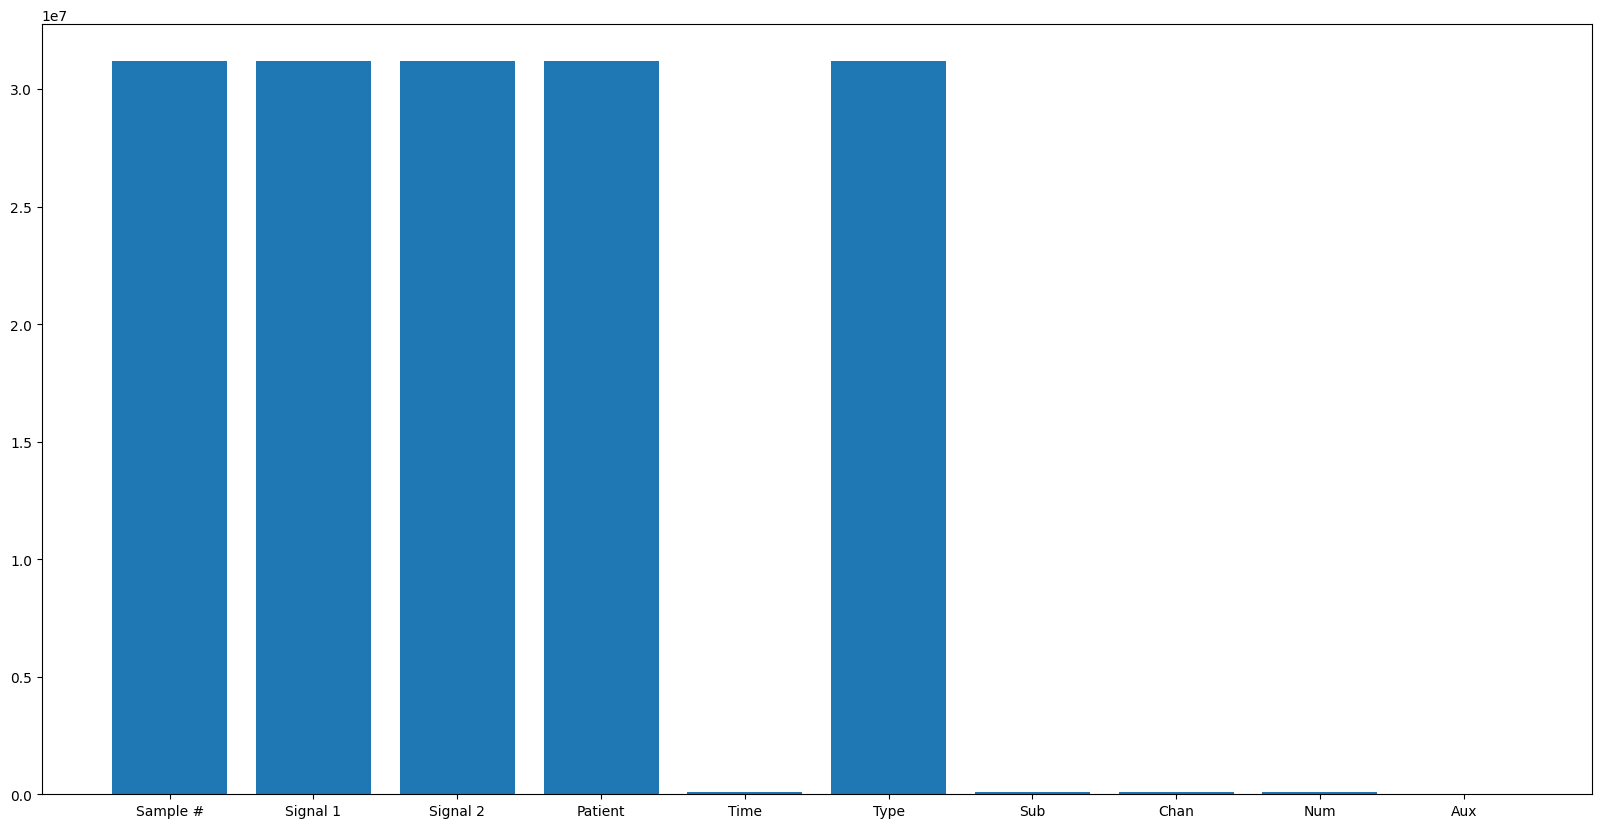

In [141]:
# For each feature count the number of non-null values
print(df.count())

# Plot each feature count in a bar plot
plt.figure(figsize=(20, 10))
plt.bar(df.columns, df.count())

In [142]:
# Print the types of each feature
print(df.dtypes)

Sample #      int64
Signal 1      int64
Signal 2      int64
Patient      object
Time         object
Type         object
Sub         float64
Chan        float64
Num         float64
Aux          object
dtype: object


In [144]:
df.describe()

,Sample #,Signal 1,Signal 2,Sub,Chan,Num
count,3.119753e+07,3.119753e+07,3.119753e+07,112646.000000,112646.0,112646.0
mean,3.250252e+05,9.562826e+02,1.001037e+03,0.062603,0.0,0.0
std,1.876240e+05,9.447422e+01,8.981329e+01,0.406945,0.0,0.0
min,0.000000e+00,0.000000e+00,0.000000e+00,-1.000000,0.0,0.0
25%,1.625380e+05,9.070000e+02,9.510000e+02,0.000000,0.0,0.0
50%,3.250250e+05,9.650000e+02,1.019000e+03,0.000000,0.0,0.0
75%,4.875120e+05,9.950000e+02,1.047000e+03,0.000000,0.0,0.0
max,6.499990e+05,2.047000e+03,2.047000e+03,9.000000,0.0,0.0


array([[<AxesSubplot: title={'center': 'Sample #'}>,
        <AxesSubplot: title={'center': 'Signal 1'}>],
       [<AxesSubplot: title={'center': 'Signal 2'}>,
        <AxesSubplot: title={'center': 'Sub'}>],
       [<AxesSubplot: title={'center': 'Chan'}>,
        <AxesSubplot: title={'center': 'Num'}>]], dtype=object)

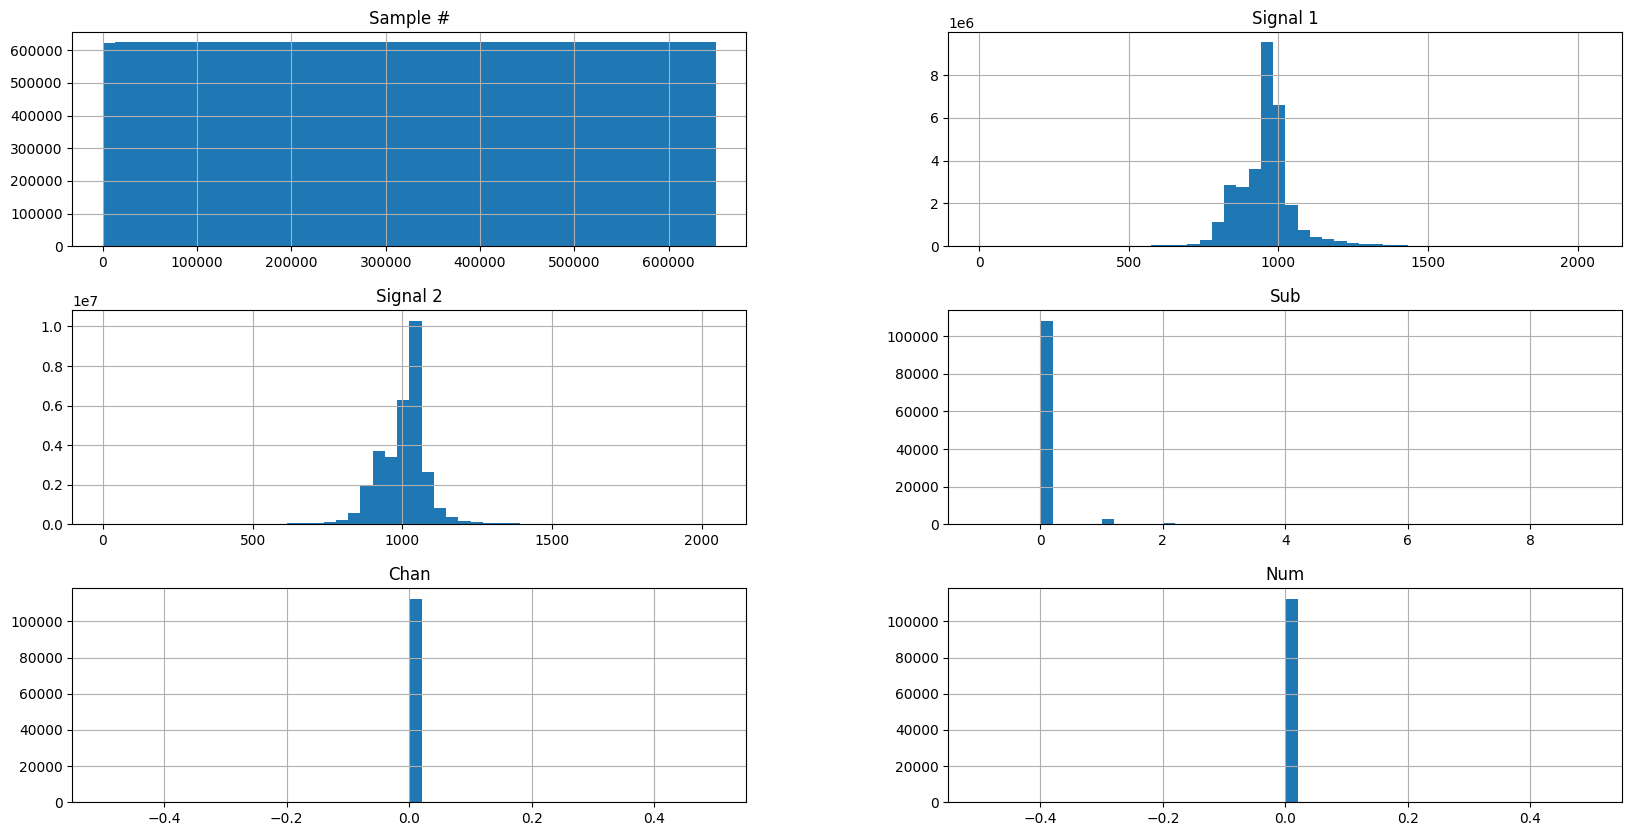

In [145]:
# Plot features histograms with the NaN values removed
df.hist(figsize=(20, 10), bins=50)

In [147]:
# Scaling MLII, V1, V2, V4 and V5
scaler = MinMaxScaler()
Signal1 = df['Signal 1'].to_numpy()
Signal2 = df['Signal 2'].to_numpy()

df['Signal 1'] = scaler.fit_transform(Signal1.reshape(-1, 1))
df['Signal 2'] = scaler.fit_transform(Signal2.reshape(-1, 1))

In [148]:
# Filtering MLII, V1, V2, V4 and V5 with moving average
df['Signal 1'] = df['Signal 1'].rolling(window=8, min_periods=1).mean()
df['Signal 2'] = df['Signal 2'].rolling(window=8, min_periods=1).mean()

In [155]:
# Create beat_df DataFrame
beat_df = pd.DataFrame({
    'sample1': df_copy['Sample #'][0:-1].reset_index(drop=True),
    'sample2': df_copy['Sample #'][1:].reset_index(drop=True),
    'Type': df_copy['Type'][0:-1].reset_index(drop=True),
    'Patient': df_copy['Patient'][0:-1].reset_index(drop=True)})

# Add Heartbeat # column
beat_df['Heartbeat #'] = beat_df.index

# Reset the index for the new DataFrame
beat_df.reset_index(drop=True, inplace=True)

# Add a column to beat_df with the length of each heartbeat
beat_df['RR interval'] = (beat_df['sample2'] - beat_df['sample1']) / 360

mean_list = []
std_list = []

beat_df = pd.DataFrame({
    'sample1': df_copy['Sample #'][0:-1].reset_index(drop=True),
    'sample2': df_copy['Sample #'][1:].reset_index(drop=True)})

# Add Heartbeat # column
beat_df['Heartbeat #'] = beat_df.index

# Reset the index for the new DataFrame
beat_df.reset_index(drop=True, inplace=True)

# Add a column to beat_df with the length of each heartbeat
beat_df['RR interval'] = (beat_df['sample2'] - beat_df['sample1']) / 360

mean_list = []
std_list = []
patient_list = []
type_list = []

# Look up the values for MLII and V5 in df between sample1 and sample2 in beat_df
for patient_id in df['Patient'].unique():
    print(patient_id)
    for index, row in beat_df.loc[df_copy['Patient'] == patient_id].iterrows():
        sample1 = int(row['sample1'])
        sample2 = int(row['sample2'])

        # Calculate mean and std values for MLII
        mean_value = df['Signal 1'][sample1:sample2].mean()
        std = df['Signal 1'][sample1:sample2].std()
        mean_list.append(mean_value)
        std_list.append(std)

        #patient = [patient_id] * len(mean_list)
        patient_list.append(patient_id)
        type_list.append(df_copy['Type'][index])

# Add a column to beat_df with the mean MLII and std values for each heartbeat
beat_df['Signal 1 mean'] = mean_list
beat_df['Signal 1 std'] = std_list
beat_df['Patient'] = patient_list
beat_df['Type'] = type_list

100
101
102
103
104
105
106
107
108
109
111
112
113
114
115
116
117
118
119
121
122
123
124
200
201
202
203
205
207
208
209
210
212
213
214
215
217
219
220
221
222
223
228
230
231
232
233
234


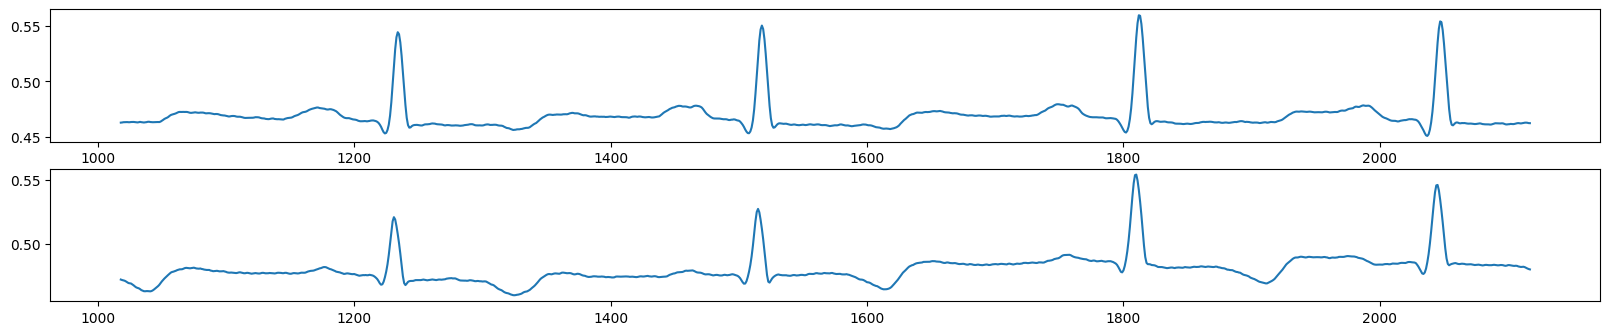

In [150]:
# Plot ecg examples with each feature in its subplot
plt.figure(figsize=(20, 10))
plt.subplot(511)
plt.plot(df['Sample #'][1000:2100], df['Signal 1'][1000:2100])
plt.subplot(512)
plt.plot(df['Sample #'][1000:2100], df['Signal 2'][1000:2100])


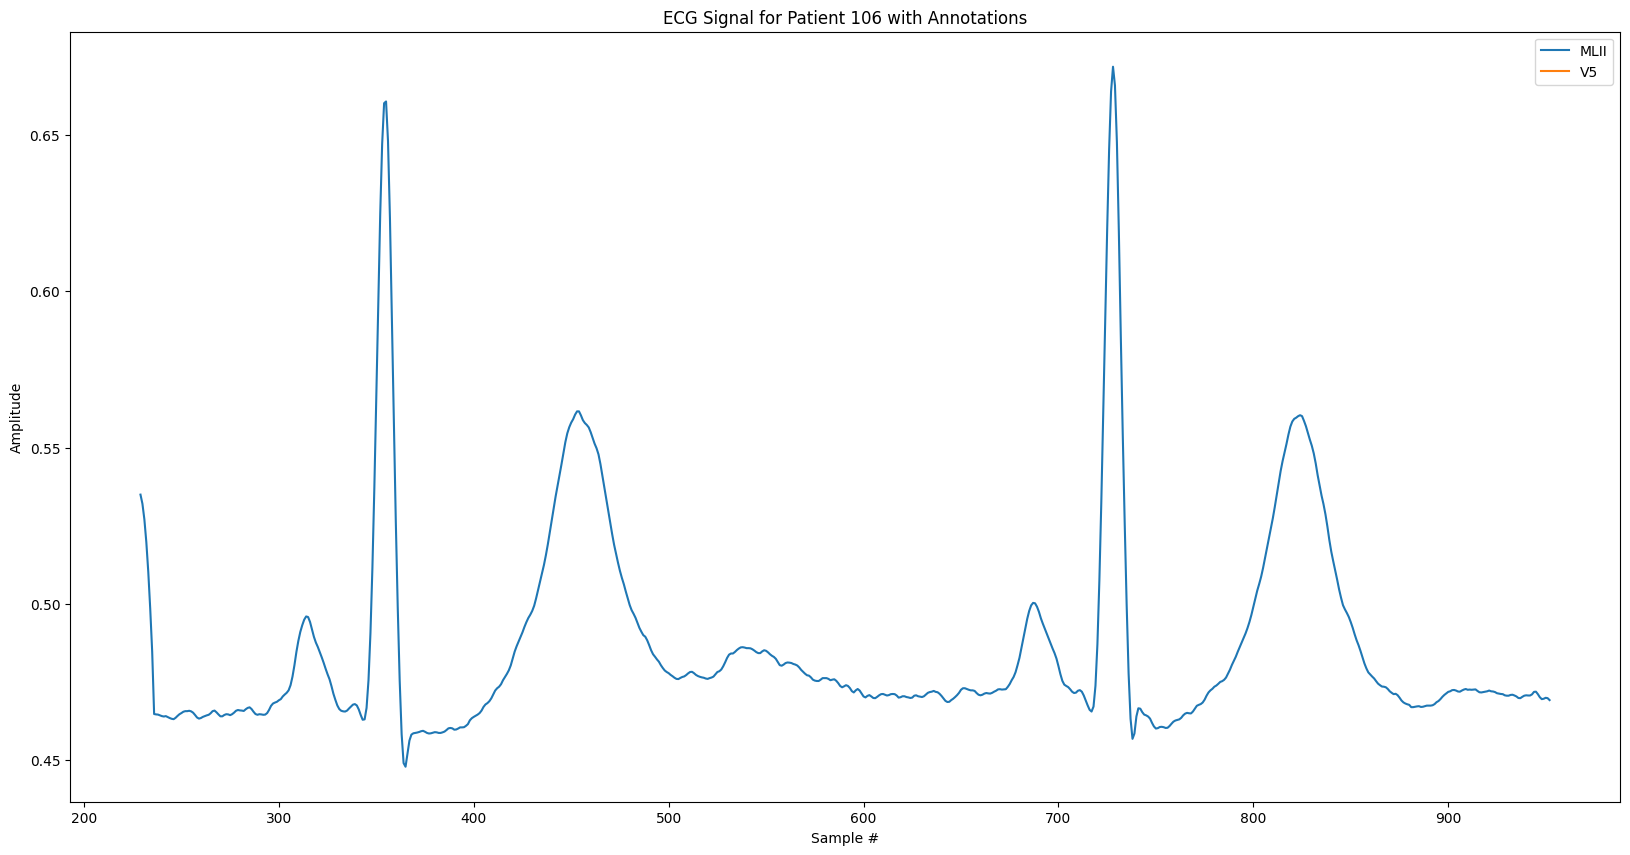

In [ ]:
patient_id = 106
ecg_data = df[df['Patient'] == str(patient_id)]

sample_range = slice(0, 724)  # Adjust the slice as needed

plt.figure(figsize=(20, 10))
plt.plot(ecg_data['Sample #'][sample_range], ecg_data['MLII'][sample_range], label='MLII')
plt.plot(ecg_data['Sample #'][sample_range], ecg_data['V5'][sample_range], label='V5')
plt.xlabel('Sample #')
plt.ylabel('Amplitude')
plt.legend()
plt.title(f'ECG Signal for Patient {patient_id} with Annotations')
plt.show()

In [ ]:
print(df[649980:650000])

        Sample #      MLII        V5 Patient        V1  V2  V4      Time Type  \
649980    649998  0.511847  0.494088     100       NaN NaN NaN       NaN    N   
649981    649999  0.484978  0.484797     100       NaN NaN NaN       NaN    N   
649982         7  0.469834  0.475708     101  0.484612 NaN NaN  0:00.019    +   
649983         8  0.457010  0.476351     101  0.485100 NaN NaN       NaN    +   
649984         9  0.448522  0.483559     101  0.485426 NaN NaN       NaN    +   
649985        10  0.445530  0.492680     101  0.484978 NaN NaN       NaN    +   
649986        11  0.446996  0.502628     101  0.484514 NaN NaN       NaN    +   
649987        12  0.451209  0.517455     101  0.484367 NaN NaN       NaN    +   
649988        13  0.456583  0.555180     101  0.484542 NaN NaN       NaN    +   
649989        14  0.468368       NaN     101  0.484551 NaN NaN       NaN    +   
649990        15  0.468857       NaN     101  0.484428 NaN NaN       NaN    +   
649991        16  0.469223  